In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/energy_data.csv')

In [3]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957301 entries, 0 to 1957300
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   building_id        int64  
 1   timestamp          object 
 2   site_id            int64  
 3   primary_use        object 
 4   square_feet        int64  
 5   year_built         float64
 6   floor_count        float64
 7   air_temperature    float64
 8   cloud_coverage     float64
 9   dew_temperature    float64
 10  precip_depth_1_hr  float64
 11  target             float64
dtypes: float64(7), int64(3), object(2)
memory usage: 179.2+ MB


,building_id,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,target
0,107,2016-01-01 00:00:00,1,Education,97532,2005.0,10.0,3.8,0.0,2.4,0.0,175.1840
1,108,2016-01-01 00:00:00,1,Education,81580,1913.0,5.0,3.8,0.0,2.4,0.0,91.2653
2,109,2016-01-01 00:00:00,1,Education,56995,1953.0,6.0,3.8,0.0,2.4,0.0,80.9300
3,110,2016-01-01 00:00:00,1,Education,27814,2006.0,8.0,3.8,0.0,2.4,0.0,86.2283
4,111,2016-01-01 00:00:00,1,Education,118338,1909.0,7.0,3.8,0.0,2.4,0.0,167.3920


In [4]:
# Check for missing values
df.isnull().sum()

building_id          0
timestamp            0
site_id              0
primary_use          0
square_feet          0
year_built           0
floor_count          0
air_temperature      0
cloud_coverage       0
dew_temperature      0
precip_depth_1_hr    0
target               0
dtype: int64

1. Mean target variable (energy consumption) for each month

/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_15070/95451498.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df[['timestamp', 'target']].set_index('timestamp').resample('H').mean()['target'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Target', fontsize=14)


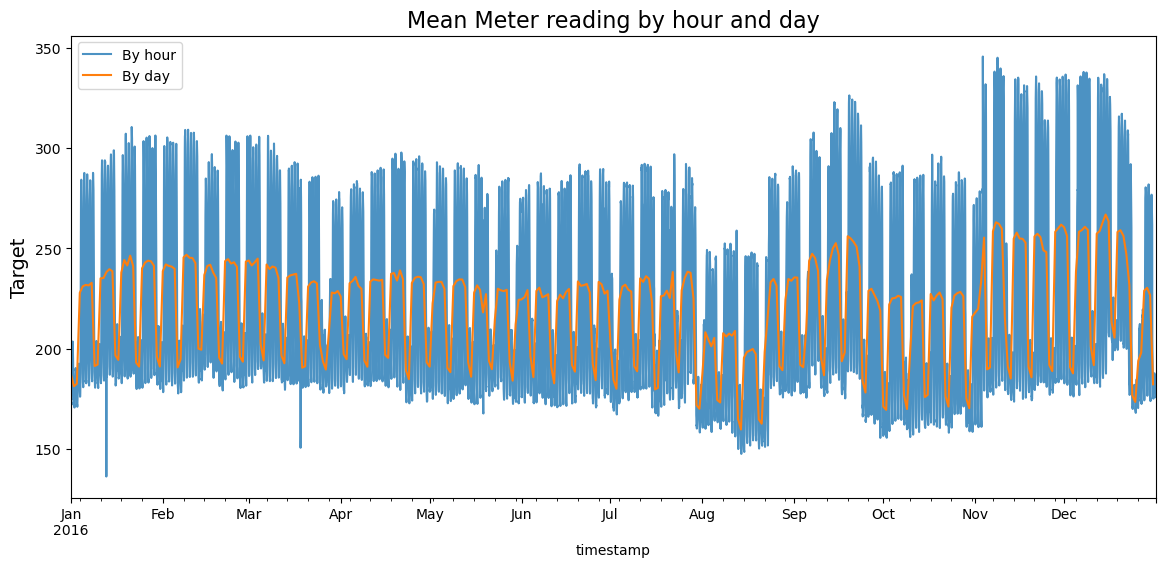

In [5]:
# Ensure the timestamp column is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plot the data
fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi=100)
df[['timestamp', 'target']].set_index('timestamp').resample('H').mean()['target'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Target', fontsize=14)
df[['timestamp', 'target']].set_index('timestamp').resample('D').mean()['target'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Target', fontsize=14)
axes.set_title('Mean Meter reading by hour and day', fontsize=16)
axes.legend()

Number of unique sites: [1 4 5 7]


/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_15070/3013168032.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df[df['site_id'] == site_id][['timestamp', 'target']].set_index('timestamp').resample('H').mean()['target'].plot(
/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_15070/3013168032.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df[df['site_id'] == site_id][['timestamp', 'target']].set_index('timestamp').resample('H').mean()['target'].plot(
/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_15070/3013168032.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df[df['site_id'] == site_id][['timestamp', 'target']].set_index('timestamp').resample('H').mean()['target'].plot(
/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_15070/3013168032.py:11: FutureWarning: 'H' is depr

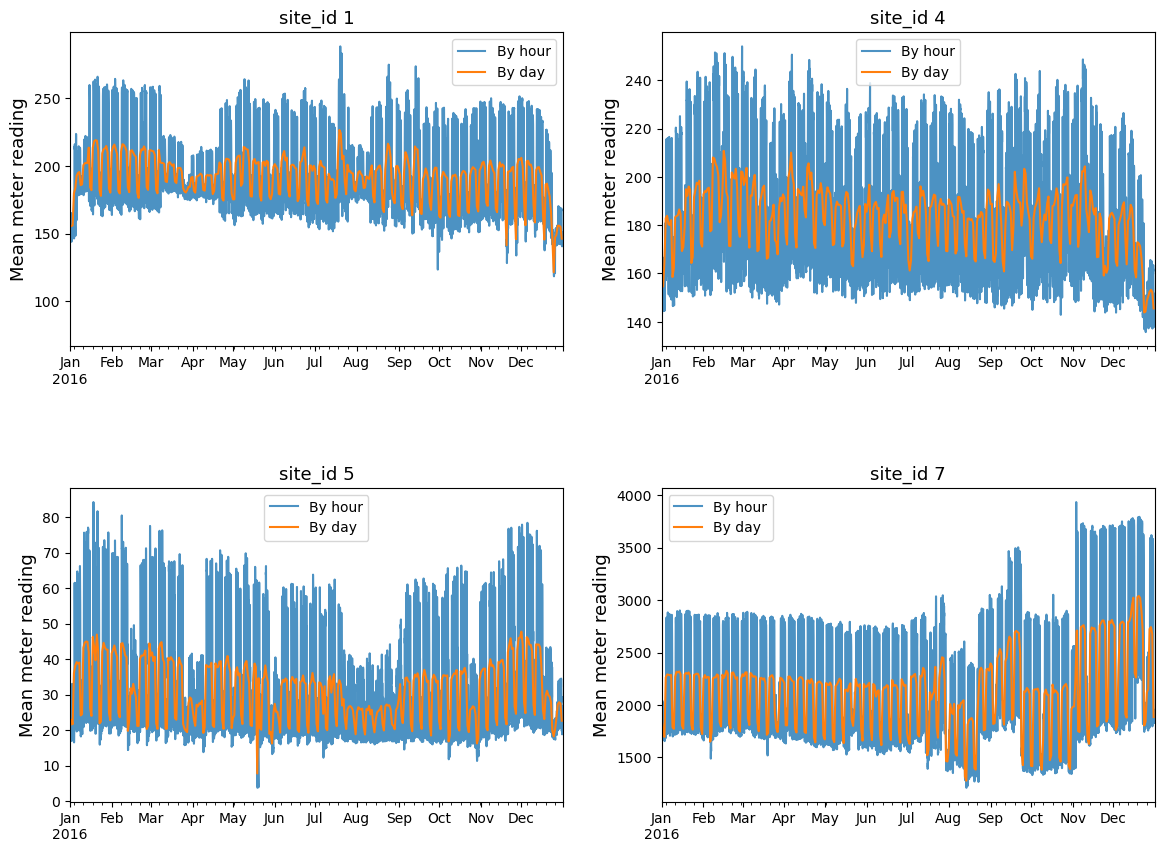

In [6]:
import matplotlib.pyplot as plt


unique_sites = df['site_id'].unique()
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

print(f'Number of unique sites: {unique_sites}')
for i, site_id in enumerate(unique_sites):
    ax = axes[i // 2, i % 2]  # Correção da indexação

    df[df['site_id'] == site_id][['timestamp', 'target']].set_index('timestamp').resample('H').mean()['target'].plot(
        ax=ax, alpha=0.8, label='By hour', color='tab:blue'
    ).set_ylabel('Mean meter reading', fontsize=13)

    df[df['site_id'] == site_id][['timestamp', 'target']].set_index('timestamp').resample('D').mean()['target'].plot(
        ax=ax, alpha=1, label='By day', color='tab:orange'
    ).set_xlabel('')

    ax.legend()
    ax.set_title(f'site_id {site_id}', fontsize=13)

plt.subplots_adjust(hspace=0.45)
plt.show()


Site_id - signifies the site where the data was collected. The target variable is energy consumption in kWh.

/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_15070/484984567.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df[df['site_id'] == site_id][['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(
/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_15070/484984567.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df[df['site_id'] == site_id][['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(
/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_15070/484984567.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df[df['site_id'] == site_id][['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(
/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_15

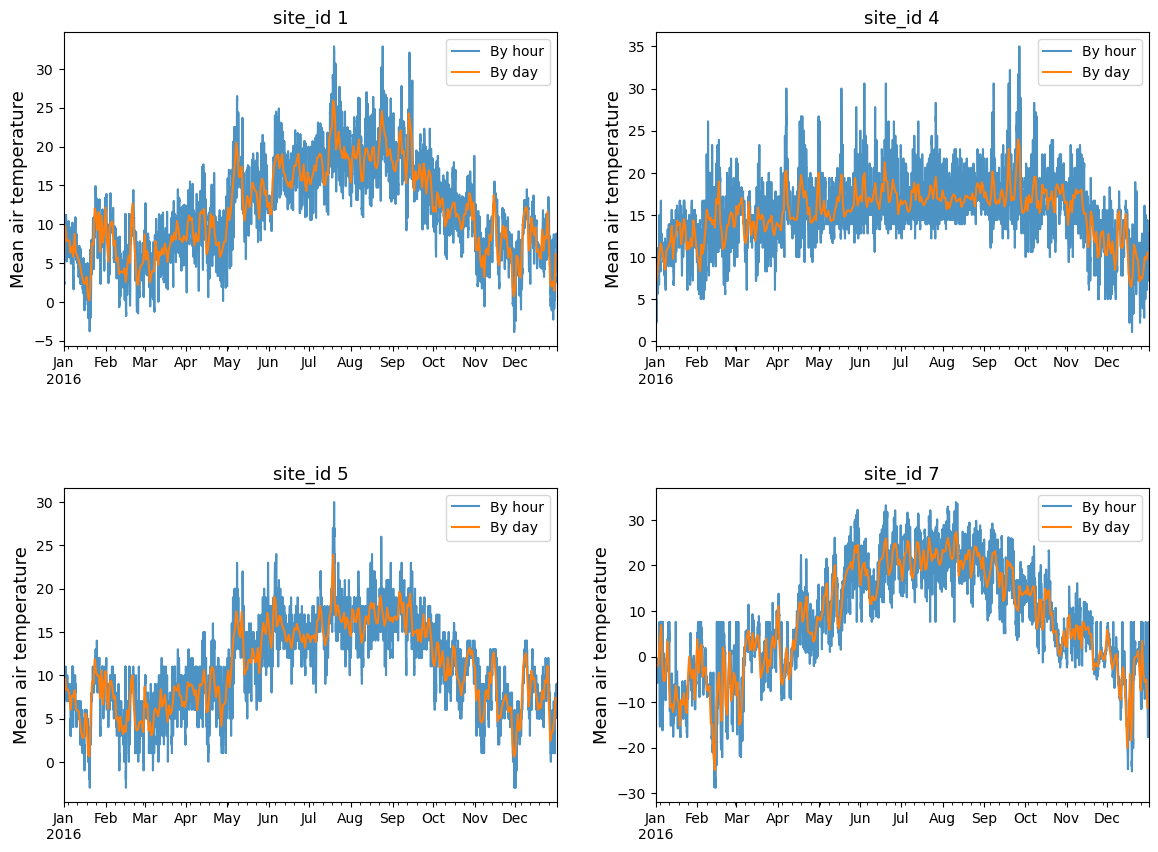

In [7]:
# Temperature
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

for i, site_id in enumerate(unique_sites):
    ax = axes[i // 2, i % 2]  # Correção da indexação

    df[df['site_id'] == site_id][['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(
        ax=ax, alpha=0.8, label='By hour', color='tab:blue'
    ).set_ylabel('Mean air temperature', fontsize=13)

    df[df['site_id'] == site_id][['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(
        ax=ax, alpha=1, label='By day', color='tab:orange'
    ).set_xlabel('')

    ax.legend()
    ax.set_title(f'site_id {site_id}', fontsize=13)
plt.subplots_adjust(hspace=0.45)
plt.show()

/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_15070/3226342041.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df[df['primary_use'] == primary_use][['timestamp', 'target']].set_index('timestamp').resample('H').mean()['target'].plot(
/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_15070/3226342041.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df[df['primary_use'] == primary_use][['timestamp', 'target']].set_index('timestamp').resample('H').mean()['target'].plot(
/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_15070/3226342041.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df[df['primary_use'] == primary_use][['timestamp', 'target']].set_index('timestamp').resample('H').mean()['target'].plot(
/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_15070/3226342041.py:8: Future

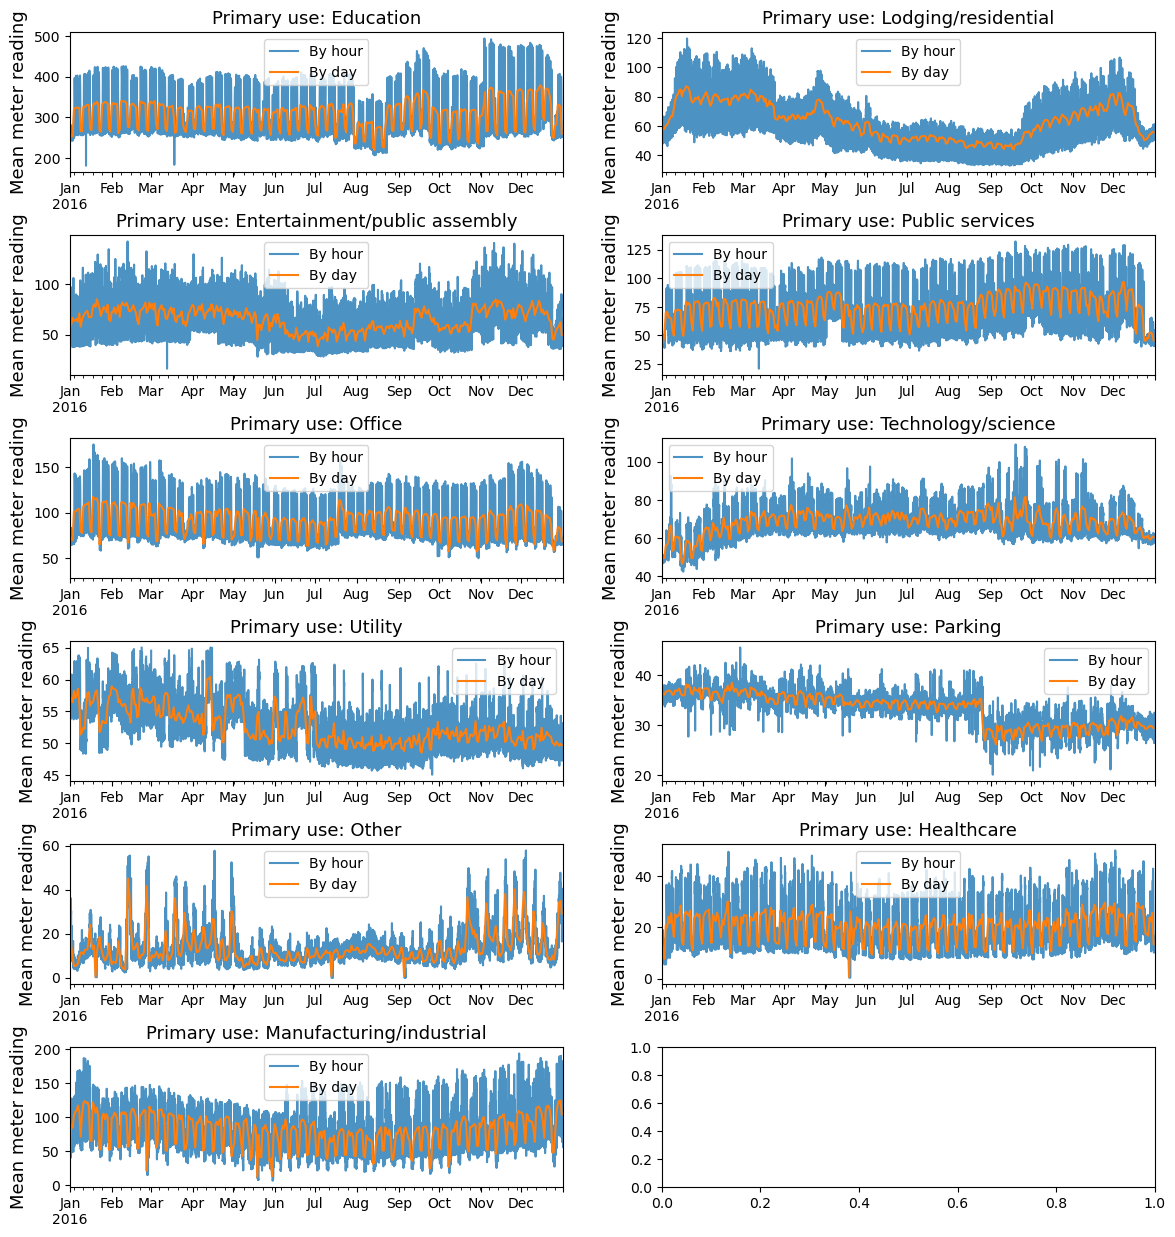

In [8]:
primary_use_types = df['primary_use'].unique()

fig, axes = plt.subplots(6, 2, figsize=(14, 15), dpi=100)

for i, primary_use in enumerate(primary_use_types):
    ax = axes[i // 2, i % 2]  # Corrected index calculation

    df[df['primary_use'] == primary_use][['timestamp', 'target']].set_index('timestamp').resample('H').mean()['target'].plot(
        ax=ax, alpha=0.8, label='By hour', color='tab:blue'
    )
    
    df[df['primary_use'] == primary_use][['timestamp', 'target']].set_index('timestamp').resample('D').mean()['target'].plot(
        ax=ax, alpha=1, label='By day', color='tab:orange'
    )

    ax.set_ylabel('Mean meter reading', fontsize=13)
    ax.set_xlabel('')
    ax.legend()
    ax.set_title(f'Primary use: {primary_use}', fontsize=13)

plt.subplots_adjust(hspace=0.45)
plt.show()


2. Number of observations by day
This is something interesting. We can see that number of observations by day is not the same in the training set.

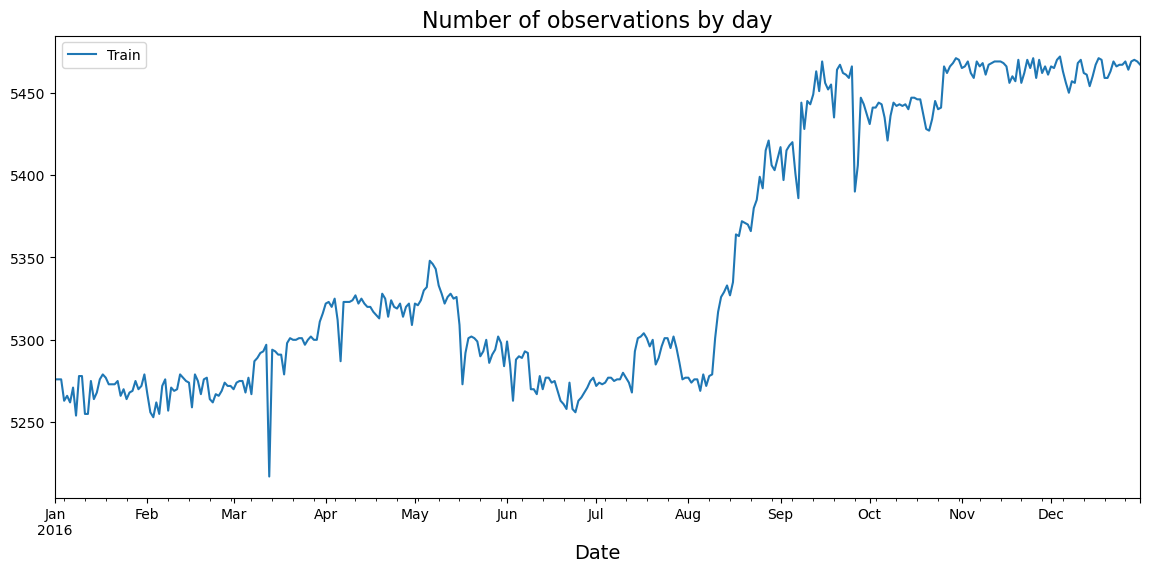

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
df['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_xlabel('Date', fontsize=14);
axes.set_title('Number of observations by day', fontsize=16);
axes.legend(['Train', 'Test']);

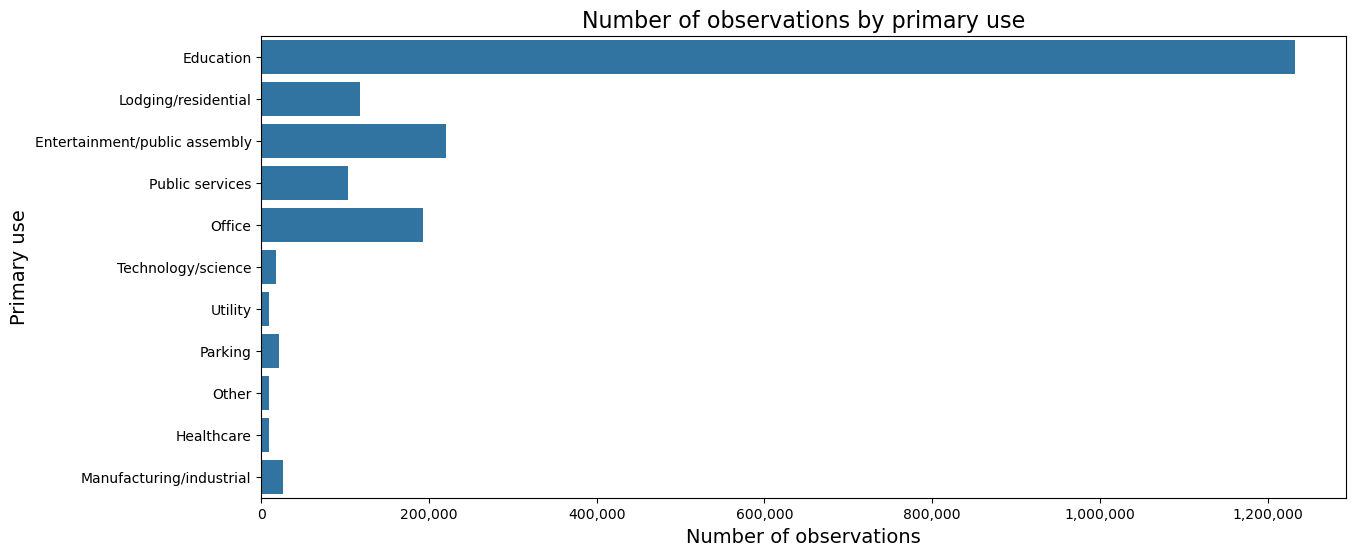

In [10]:
from matplotlib.ticker import FuncFormatter

# number of observations by primary use
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.countplot(data=df, y='primary_use', ax=axes)
axes.set_ylabel('Primary use', fontsize=14)
axes.set_xlabel('Number of observations', fontsize=14)
axes.set_title('Number of observations by primary use', fontsize=16)

# Format x-axis to show numbers in hundreds
formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
axes.xaxis.set_major_formatter(formatter)


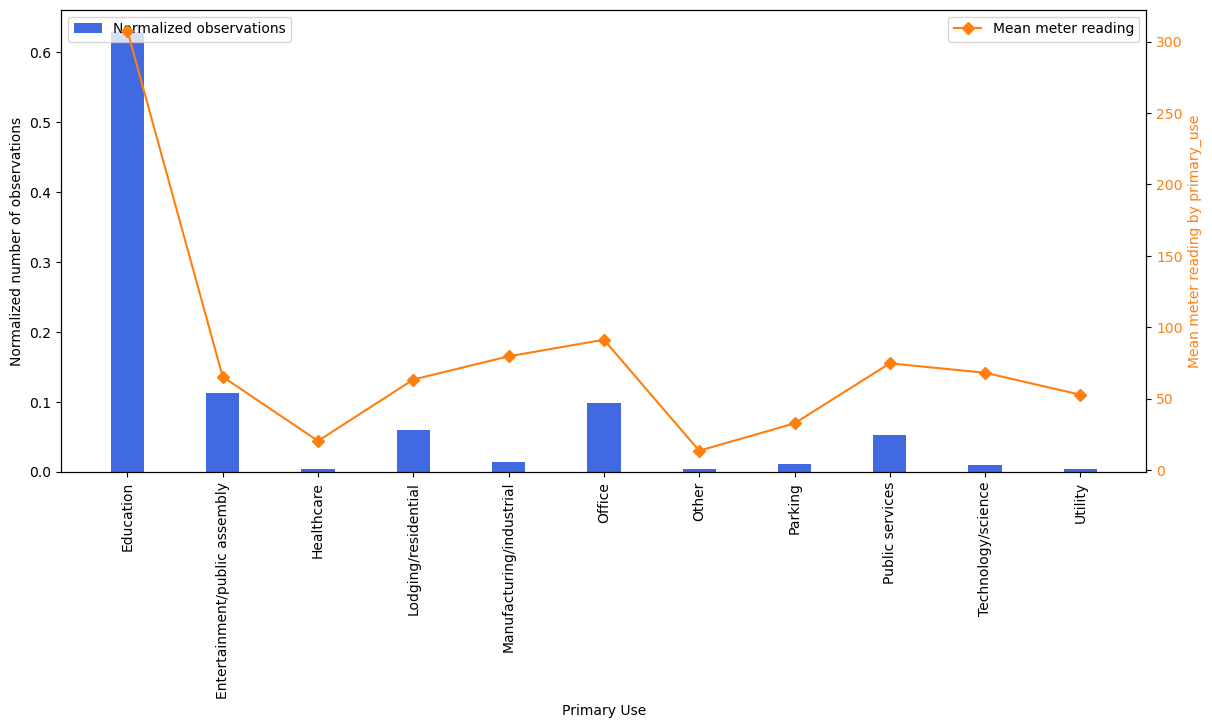

In [11]:
train_data = df['primary_use'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(figsize=(14, 6), dpi=100)
bars = axes.bar(ind, train_data, width, color='royalblue', label='Normalized observations')

axes.set_ylabel('Normalized number of observations')
axes.set_xlabel('Primary Use')
axes.set_xticks(ind)
axes.set_xticklabels(df['primary_use'].value_counts().sort_index().index, rotation=90)

# Segundo eixo Y para a média de meter_reading
axes2 = axes.twinx()
mean_meter_reading = df.groupby('primary_use')['target'].mean().sort_index().values
line = axes2.plot(ind, mean_meter_reading, 'D-', color='tab:orange', label='Mean meter reading')

axes2.set_ylabel('Mean meter reading by primary_use', color='tab:orange')
axes2.tick_params(axis='y', labelcolor='tab:orange')
axes2.grid(False)

# Ajustando a legenda
axes.legend(loc='upper left', facecolor='white')
axes2.legend(loc='upper right', facecolor='white')

plt.show()



O gráfico de barras mostra a contagem de cada categoria, enquanto o gráfico de linha mostra a média do consumo para cada categoria. Isso ajuda a entender como o consumo varia entre as diferentes categorias de uso primário.

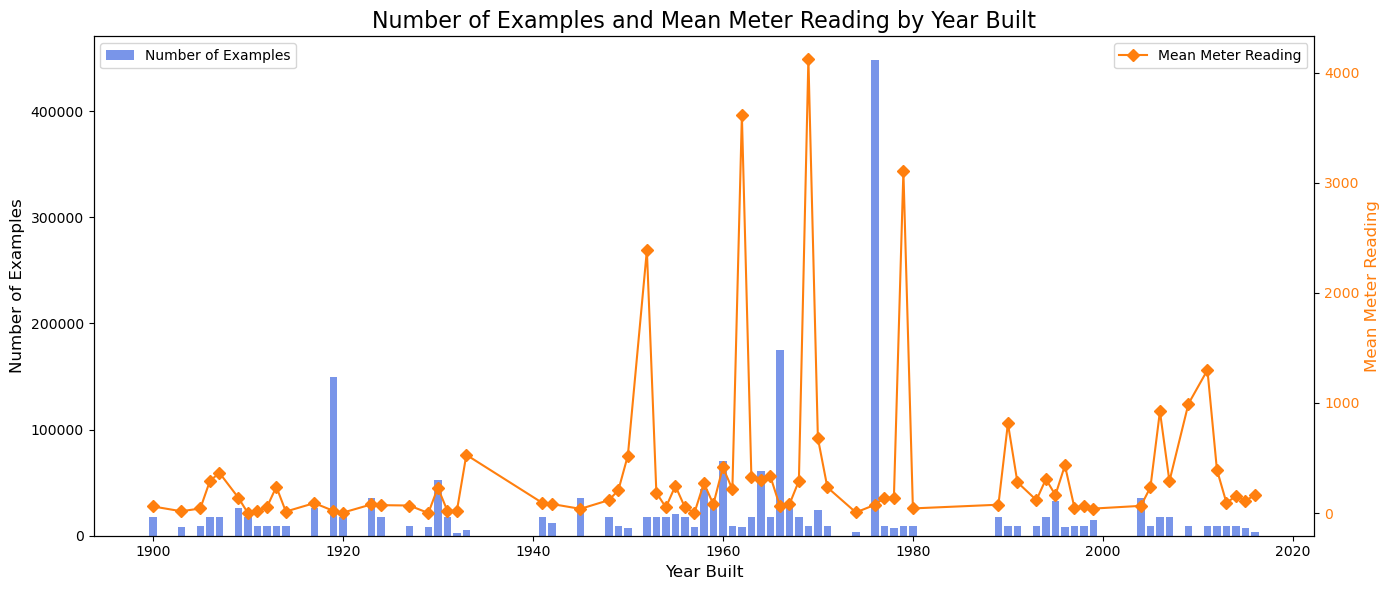

In [12]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

# Número de exemplos por ano de construção (barras)
year_counts = df['year_built'].value_counts(dropna=False).sort_index()
ax.bar(year_counts.index, year_counts.values, color='royalblue', alpha=0.7, label='Number of Examples')

ax.set_xlabel('Year Built', fontsize=12)
ax.set_ylabel('Number of Examples', fontsize=12)
ax.set_title('Number of Examples and Mean Meter Reading by Year Built', fontsize=16)

# Média de consumo por ano de construção (linha)
ax2 = ax.twinx()
mean_meter_reading = df.groupby('year_built')['target'].mean().sort_index()
ax2.plot(mean_meter_reading.index, mean_meter_reading.values, 'D-', color='tab:orange', label='Mean Meter Reading')

ax2.set_ylabel('Mean Meter Reading', fontsize=12, color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Ajustar legendas
ax.legend(loc='upper left', facecolor='white')
ax2.legend(loc='upper right', facecolor='white')

plt.tight_layout()
plt.show()

/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_15070/3103116446.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='floor_count', ax=ax, palette='viridis')


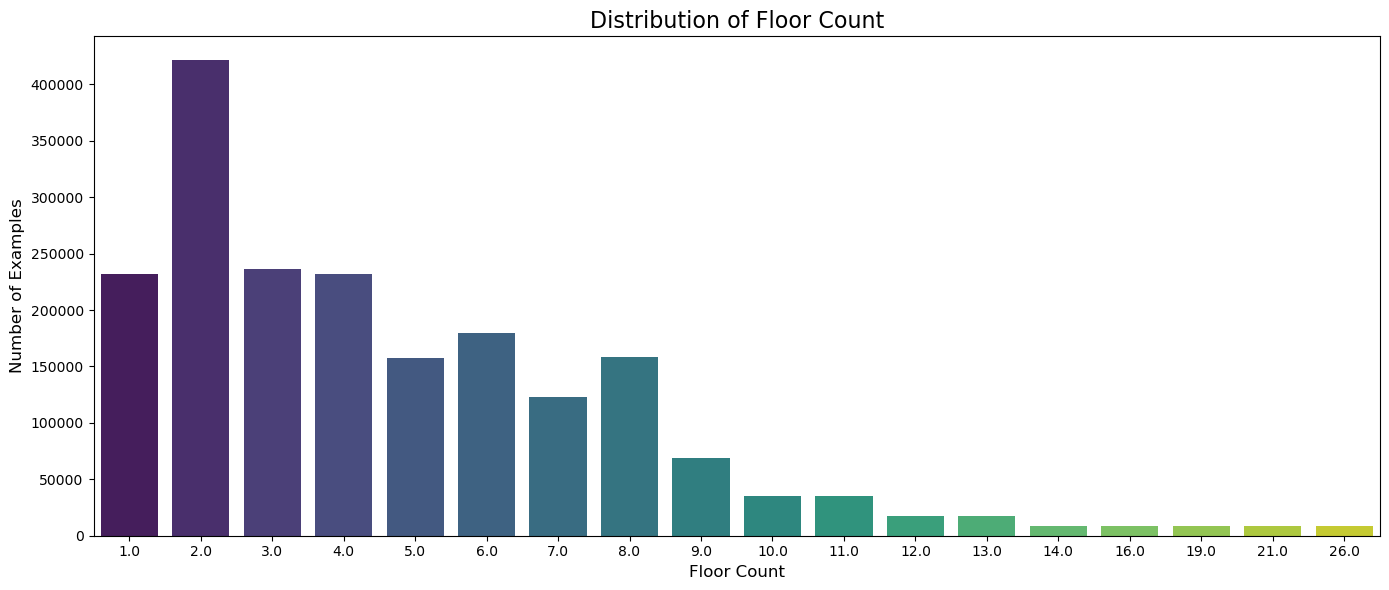

In [13]:
# Plotting the distribution of the floor count
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)
sns.countplot(data=df, x='floor_count', ax=ax, palette='viridis')
ax.set_xlabel('Floor Count', fontsize=12)
ax.set_ylabel('Number of Examples', fontsize=12)
ax.set_title('Distribution of Floor Count', fontsize=16)
plt.tight_layout()


# Feature Engineering


In [14]:
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.weekday
df['month'] = df['timestamp'].dt.month

# def create_lags(df, lags):
#     df = df.sort_values(by=["building_id", "timestamp"])  # Garantir ordenação correta
#     for lag in lags:
#         df[f'lag_{lag}h'] = df.groupby("building_id")["target"].shift(lag)
#     return df

# lags = [1, 6, 8]
# df = create_lags(df, lags) # perguntar a professora se faz sentido ter um lag diretamente ou nao


# devido ao lag vamos perder alguns valores
# df.dropna(inplace=True)
df.drop(columns=['timestamp'], inplace=True)



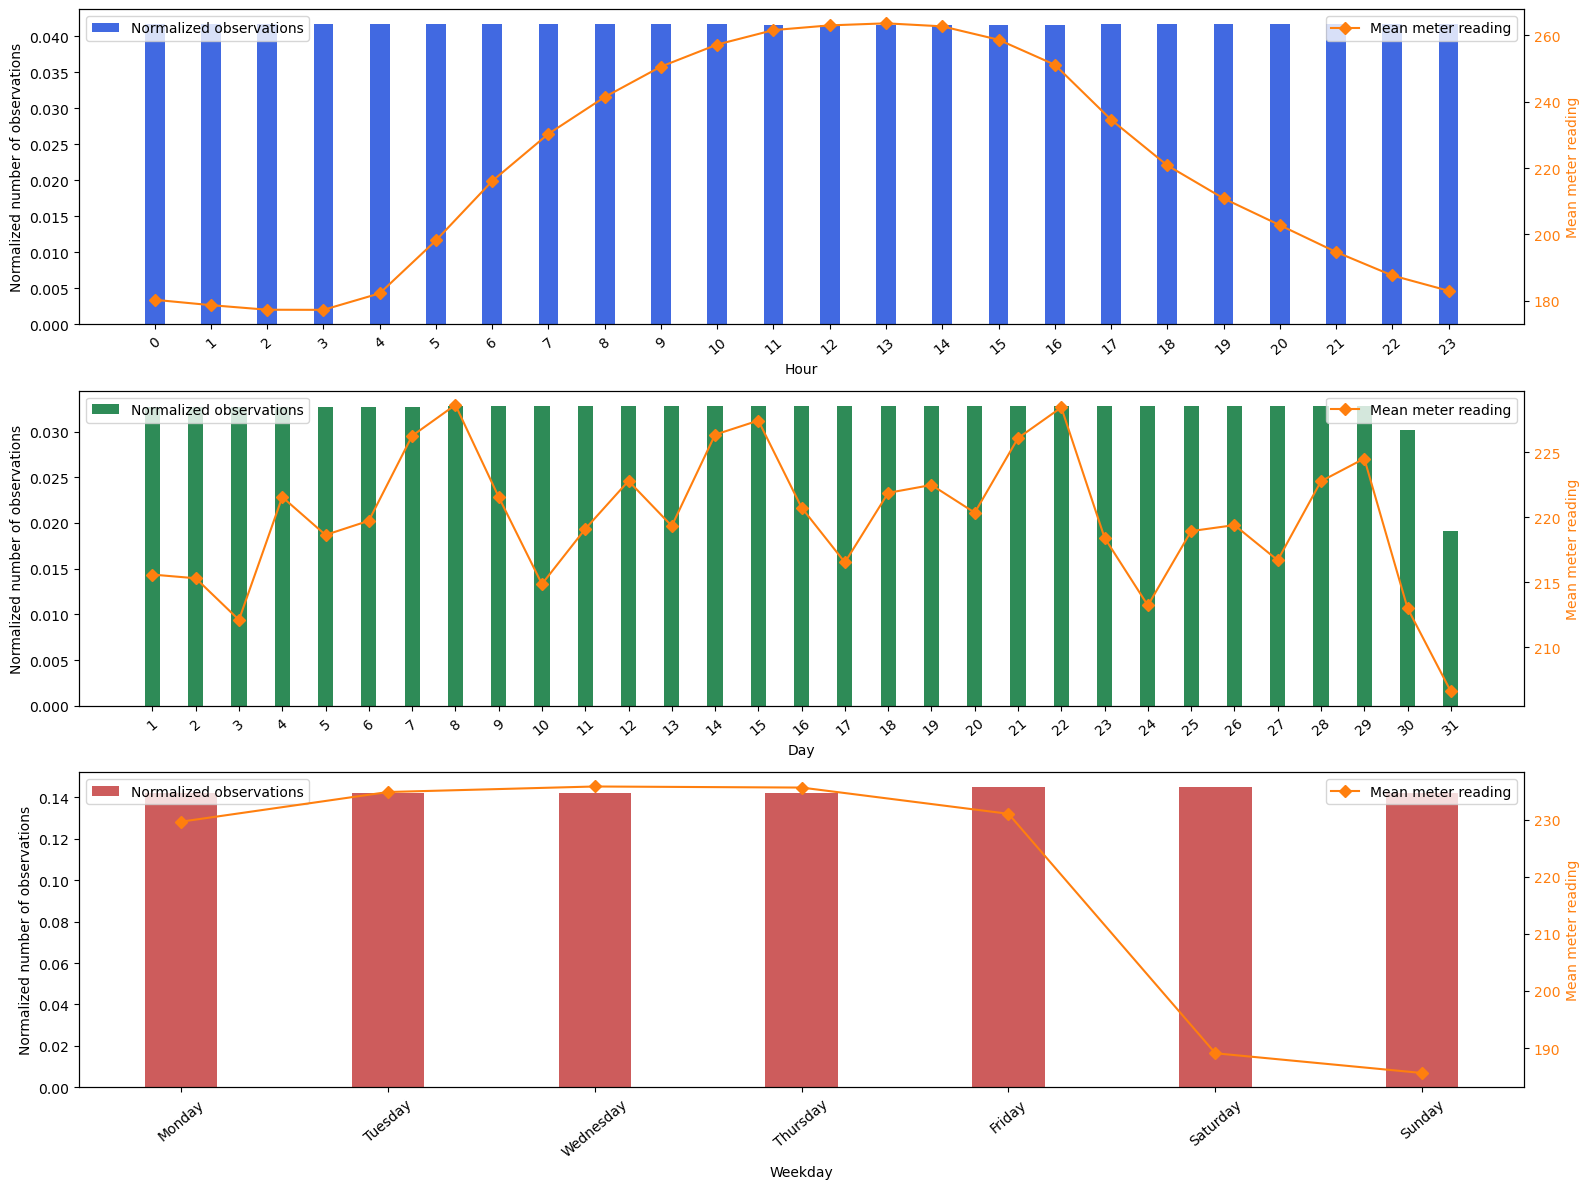

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12), dpi=100)

time_units = ['hour', 'day', 'weekday']
titles = ['Hour', 'Day', 'Weekday']
colors = ['royalblue', 'seagreen', 'indianred']

weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

for i, unit in enumerate(time_units):
    train_data = df[unit].value_counts(dropna=False, normalize=True).sort_index().values
    ind = np.arange(len(train_data))
    width = 0.35

    bars = axes[i].bar(ind, train_data, width, color=colors[i], label='Normalized observations')
    
    axes[i].set_ylabel('Normalized number of observations')
    axes[i].set_xlabel(titles[i])
    axes[i].set_xticks(ind)
    if unit == 'weekday':
        labels = df[unit].value_counts().sort_index().index.map(weekday_map)
        axes[i].set_xticklabels(labels, rotation=40)
    else:
        axes[i].set_xticklabels(df[unit].value_counts().sort_index().index, rotation=40)

    # Segundo eixo Y para a média de meter_reading
    ax2 = axes[i].twinx()
    mean_meter_reading = df.groupby(unit)['target'].mean().sort_index().values
    line = ax2.plot(ind, mean_meter_reading, 'D-', color='tab:orange', label='Mean meter reading')

    ax2.set_ylabel('Mean meter reading', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.grid(False)

    # Ajustando a legenda
    axes[i].legend(loc='upper left', facecolor='white')
    ax2.legend(loc='upper right', facecolor='white')

plt.tight_layout()
plt.show()


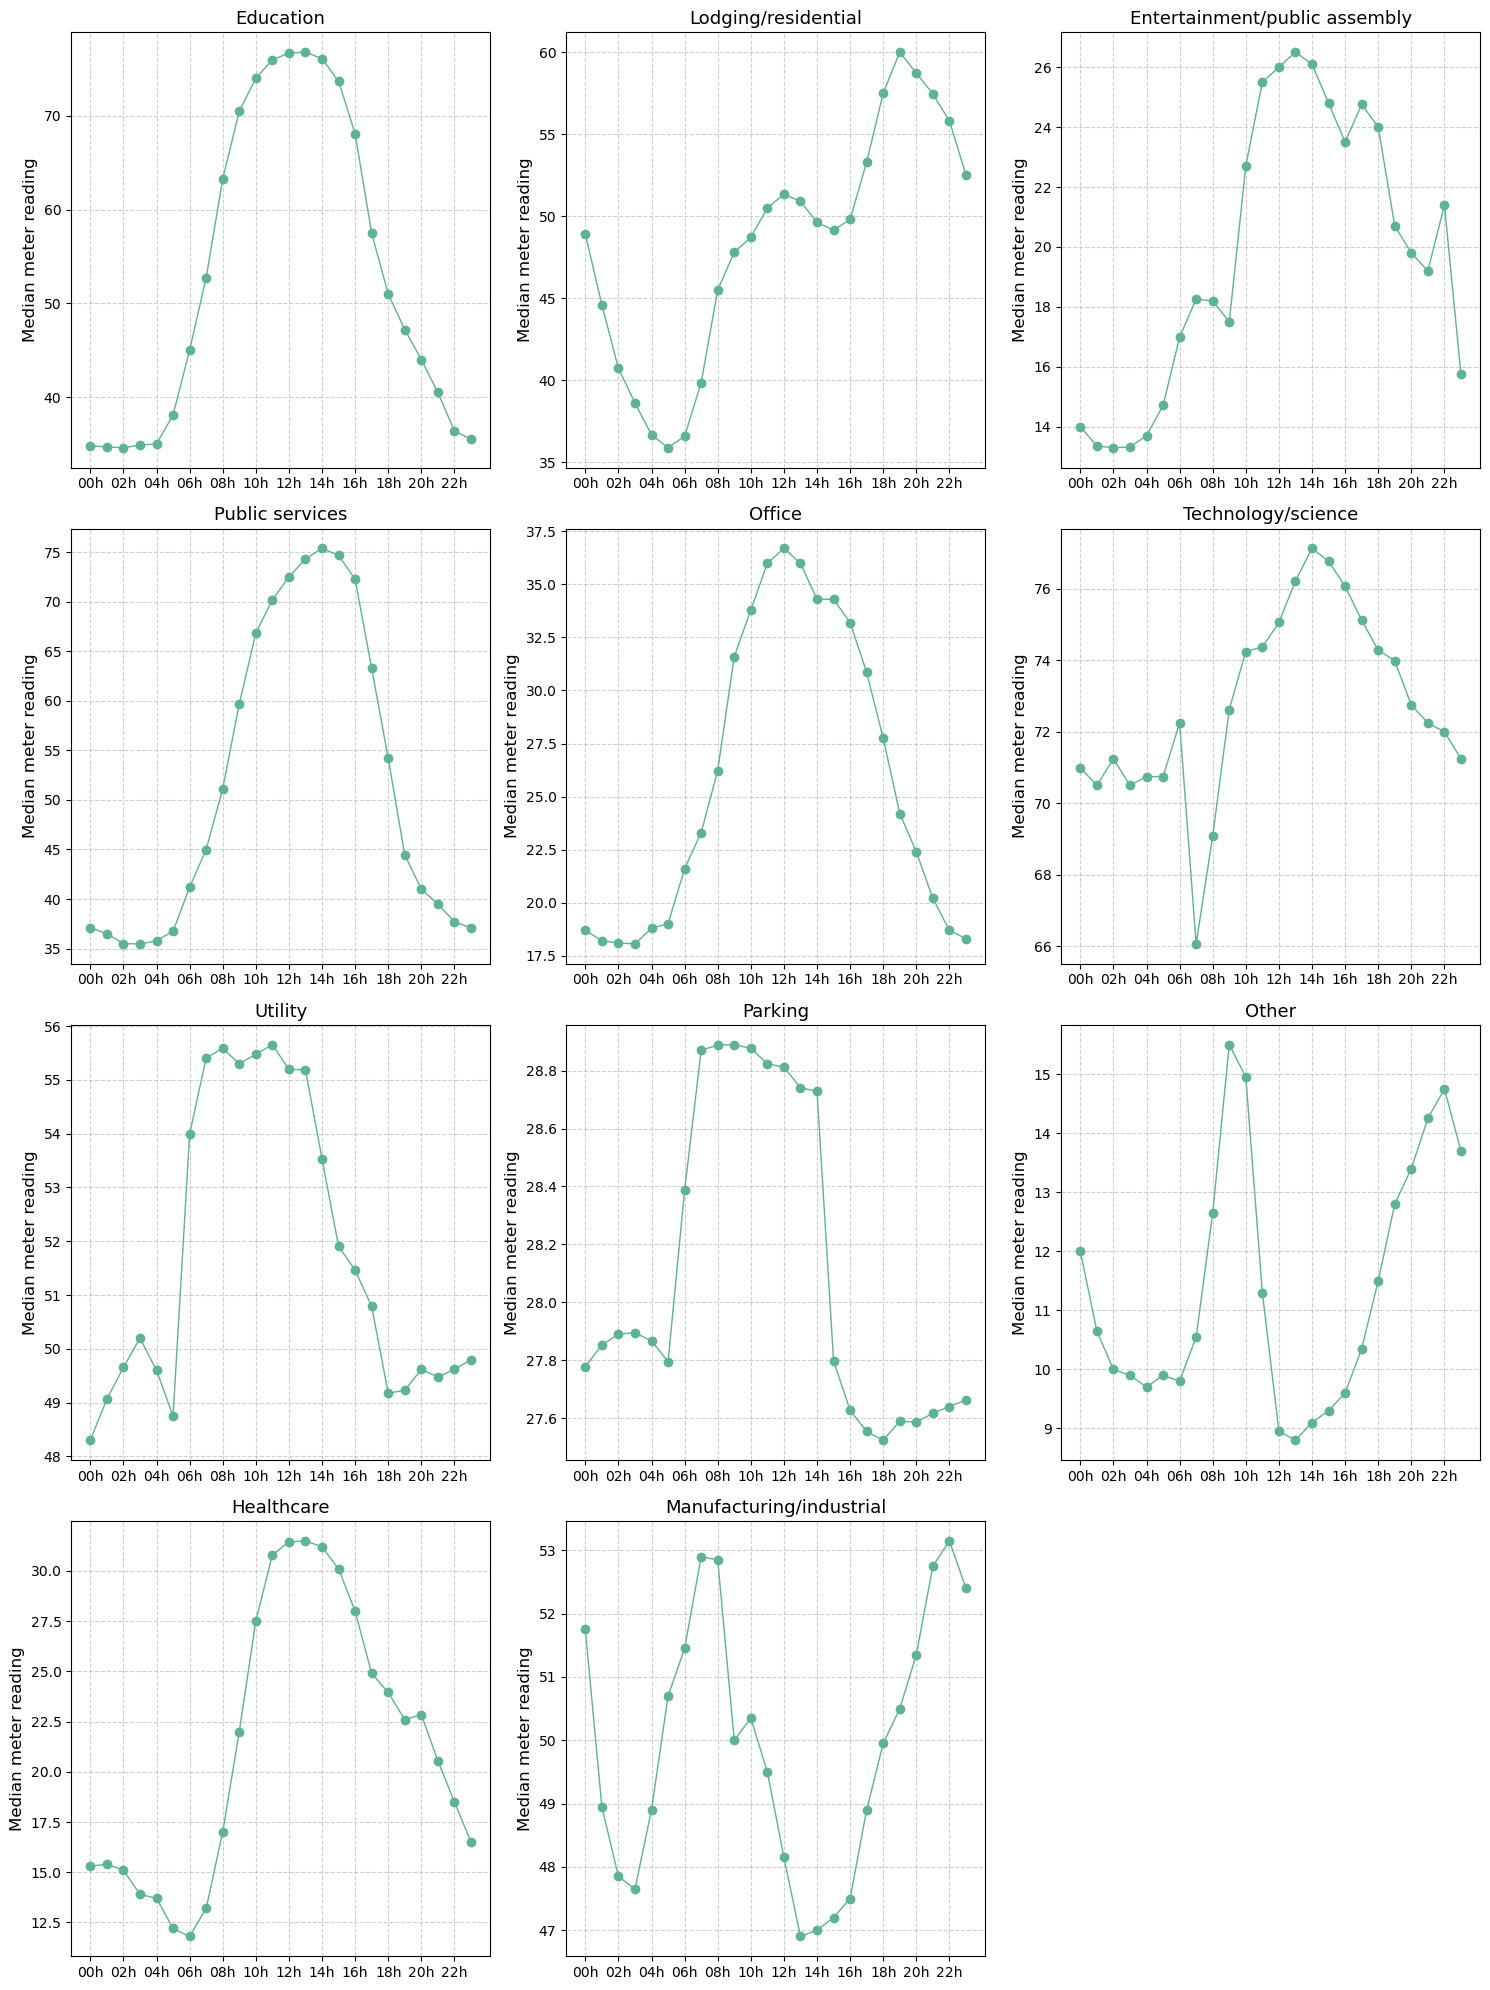

In [16]:
df_grouped = df.groupby(['hour', 'primary_use'])['target'].median().reset_index()

unique_primary_uses = df['primary_use'].unique()
num_plots = len(unique_primary_uses)

cols = 3
rows = -(-num_plots // cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), dpi=100)
axes = axes.flatten()

for i, primary_use in enumerate(unique_primary_uses):
    ax = axes[i]
    df_filtered = df_grouped[df_grouped['primary_use'] == primary_use]
    ax.plot(df_filtered['hour'], df_filtered['target'], marker='o', linestyle='-', color="#5EB296", linewidth=1)
    ax.set_title(f'{primary_use}', fontsize=13)
    ax.set_ylabel('Median meter reading', fontsize=12)
    ax.set_xticks(range(0, 24, 2))
    ax.set_xticklabels(["00h", "02h", "04h", "06h", "08h", "10h", "12h", "14h", "16h", "18h", "20h", "22h"])
    ax.grid(True, linestyle='--', alpha=0.6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


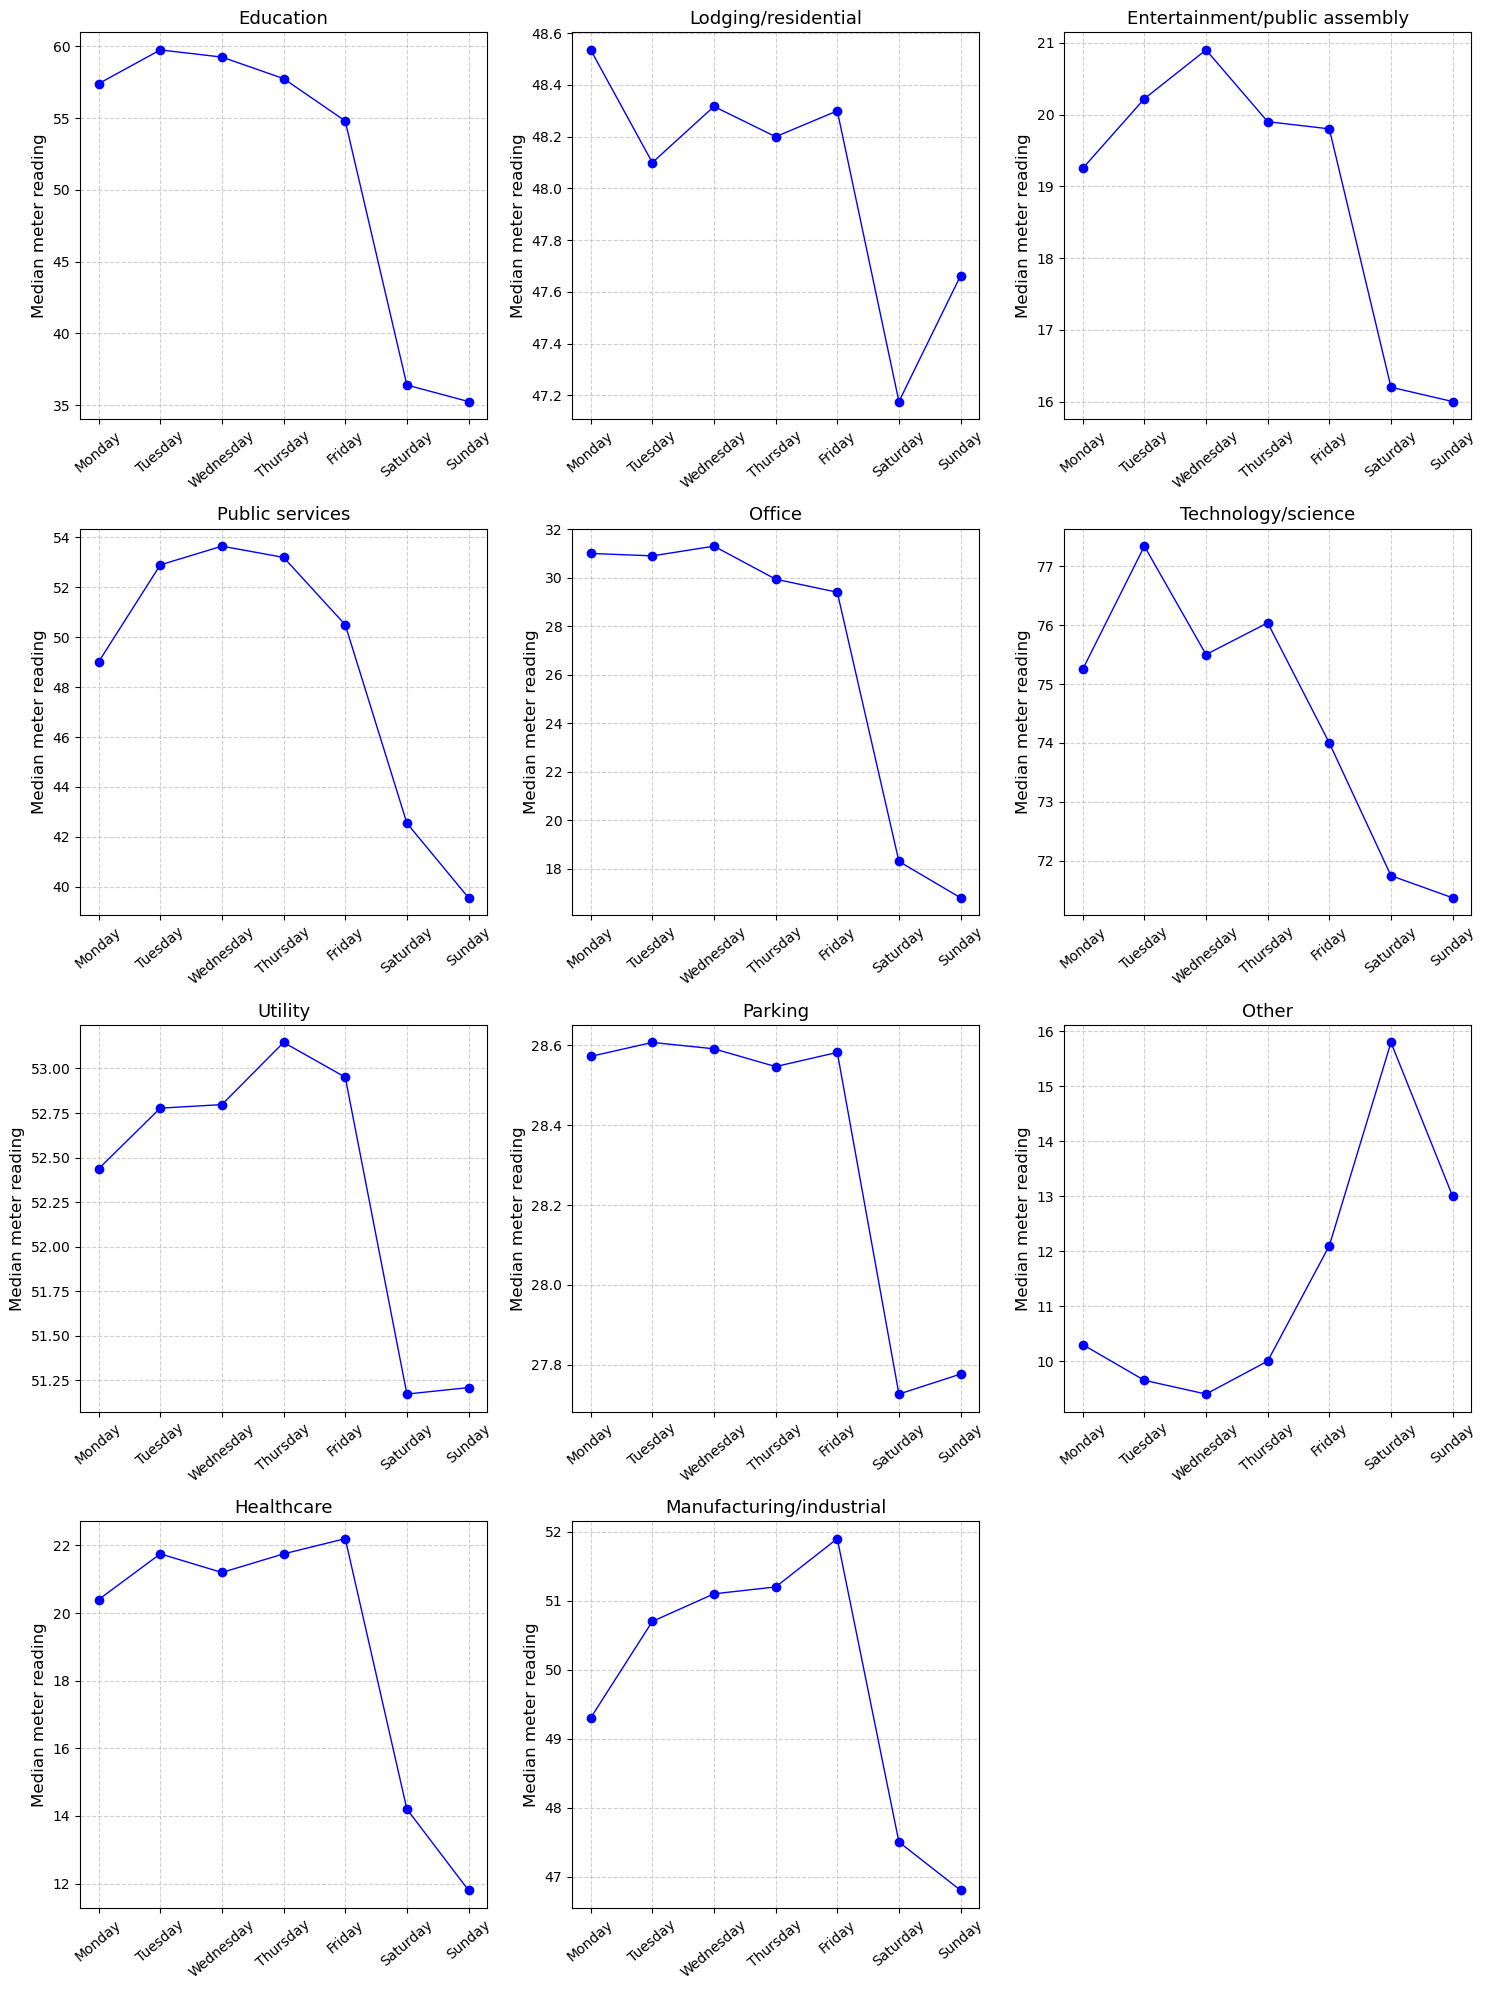

In [17]:
df_grouped_weekday = df.groupby(['weekday', 'primary_use'])['target'].median().reset_index()

unique_primary_uses = df['primary_use'].unique()
num_plots = len(unique_primary_uses)

cols = 3
rows = -(-num_plots // cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), dpi=100)
axes = axes.flatten()

for i, primary_use in enumerate(unique_primary_uses):
    ax = axes[i]
    df_filtered = df_grouped_weekday[df_grouped_weekday['primary_use'] == primary_use]
    ax.plot(df_filtered['weekday'], df_filtered['target'], marker='o', linestyle='-', color="blue", linewidth=1)
    ax.set_title(f'{primary_use}', fontsize=13)
    ax.set_ylabel('Median meter reading', fontsize=12)
    ax.set_xticks(range(7))
    ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=40)
    ax.grid(True, linestyle='--', alpha=0.6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [18]:
# cria uma variavel de m2/andar isto é o que ja existe(square_feet,year_built,floor_count)
df['m2_per_floor'] = df['square_feet'] / df['floor_count']
df['m2_per_floor'].fillna(0, inplace=True)



/var/folders/tw/4s288p5j0_g2d2pwph0rtbxw0000gn/T/ipykernel_15070/3458502132.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['m2_per_floor'].fillna(0, inplace=True)


In [19]:
from sklearn.preprocessing import LabelEncoder

# Check if 'primary_use' is already encoded
if df['primary_use'].dtype == 'object':
    le = LabelEncoder()
    df['primary_use'] = le.fit_transform(df['primary_use'])

    # Print the transformation
    print("Label Encoded primary_use:")
    for original, encoded in zip(le.classes_, range(len(le.classes_))):
        print(f"{original}: {encoded}")
else:
    print("'primary_use' is already encoded.")

# if df['season'].dtype == 'object': # Como a season nao muda nada na correlaçao nao vamos usar
#     le = LabelEncoder()
#     df['season'] = le.fit_transform(df['season'])
    
#     # Print the transformation
#     print("Label Encoded season:")
#     for original, encoded in zip(le.classes_, range(len(le.classes_))):
#         print(f"{original}: {encoded}")
# else:
#     print("'season' is already encoded.")
col = 'target'
cols = df.columns.tolist()
cols.remove(col)
cols.append(col)
df = df[cols]

df.head()

Label Encoded primary_use:
Education: 0
Entertainment/public assembly: 1
Healthcare: 2
Lodging/residential: 3
Manufacturing/industrial: 4
Office: 5
Other: 6
Parking: 7
Public services: 8
Technology/science: 9
Utility: 10


,building_id,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,day,weekday,month,m2_per_floor,target
0,107,1,0,97532,2005.0,10.0,3.8,0.0,2.4,0.0,0,1,4,1,9753.200000,175.1840
1,108,1,0,81580,1913.0,5.0,3.8,0.0,2.4,0.0,0,1,4,1,16316.000000,91.2653
2,109,1,0,56995,1953.0,6.0,3.8,0.0,2.4,0.0,0,1,4,1,9499.166667,80.9300
3,110,1,0,27814,2006.0,8.0,3.8,0.0,2.4,0.0,0,1,4,1,3476.750000,86.2283
4,111,1,0,118338,1909.0,7.0,3.8,0.0,2.4,0.0,0,1,4,1,16905.428571,167.3920


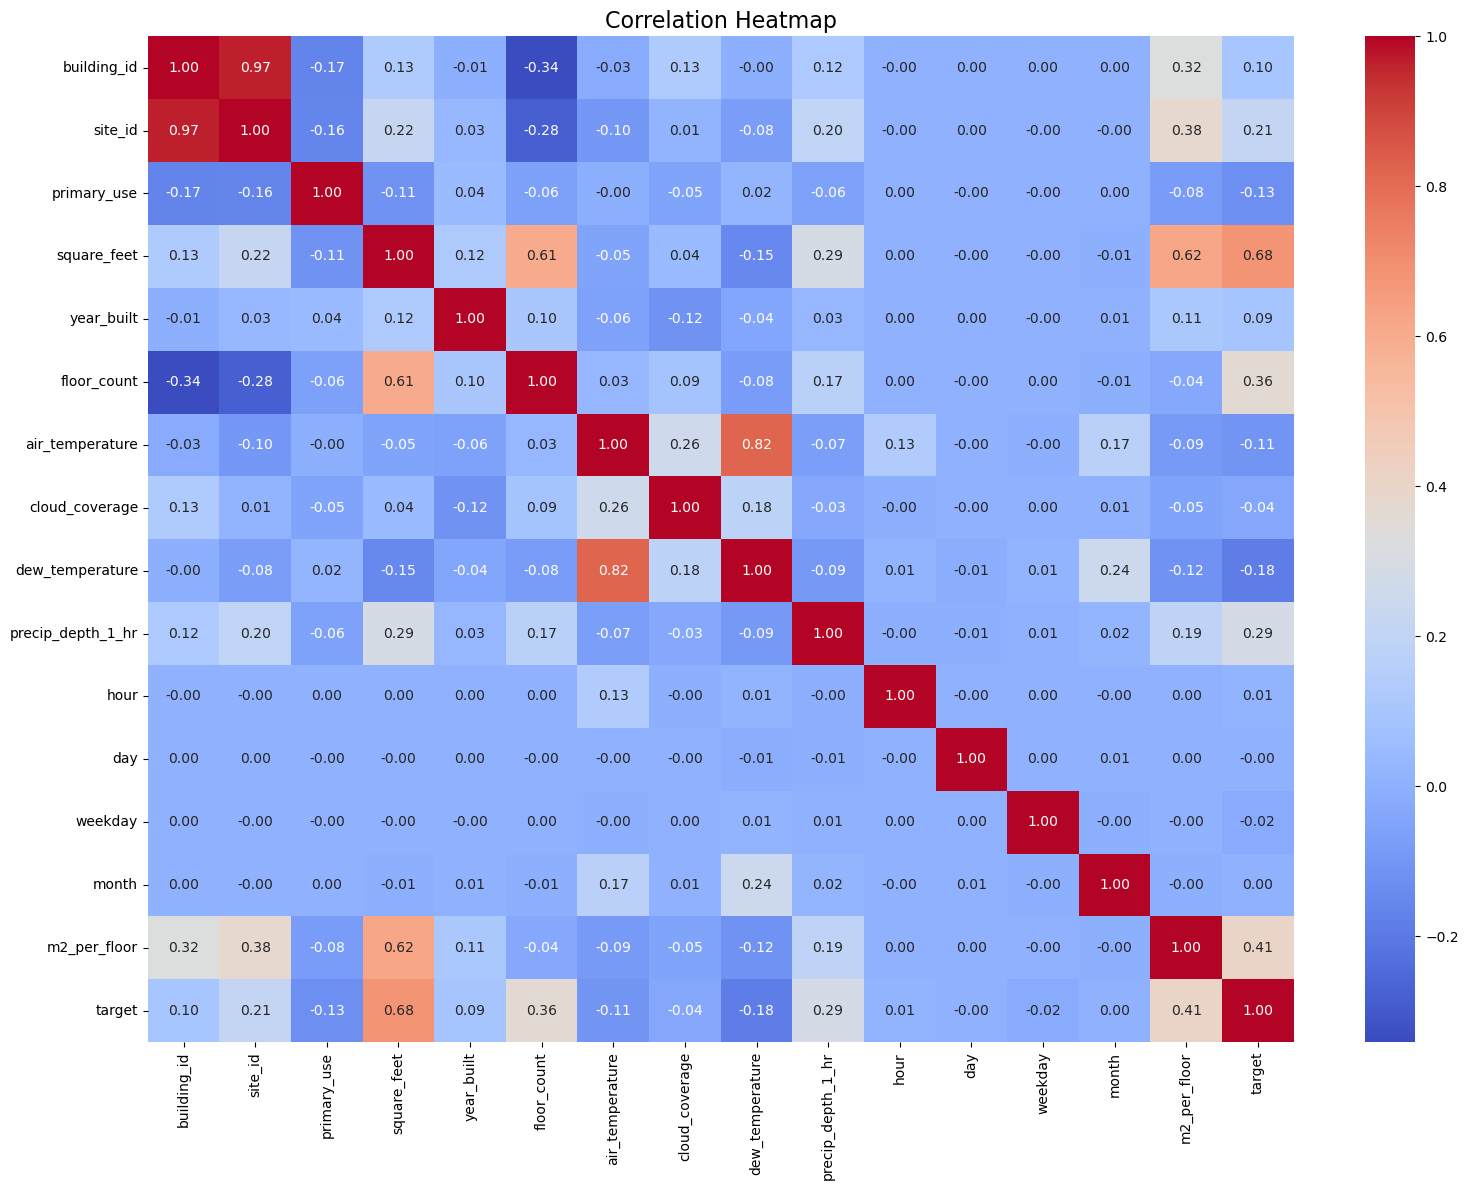

In [20]:
corr = df.corr() 
fig, ax = plt.subplots(figsize=(16, 12), dpi=100)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', ax=ax)
ax.set_title('Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

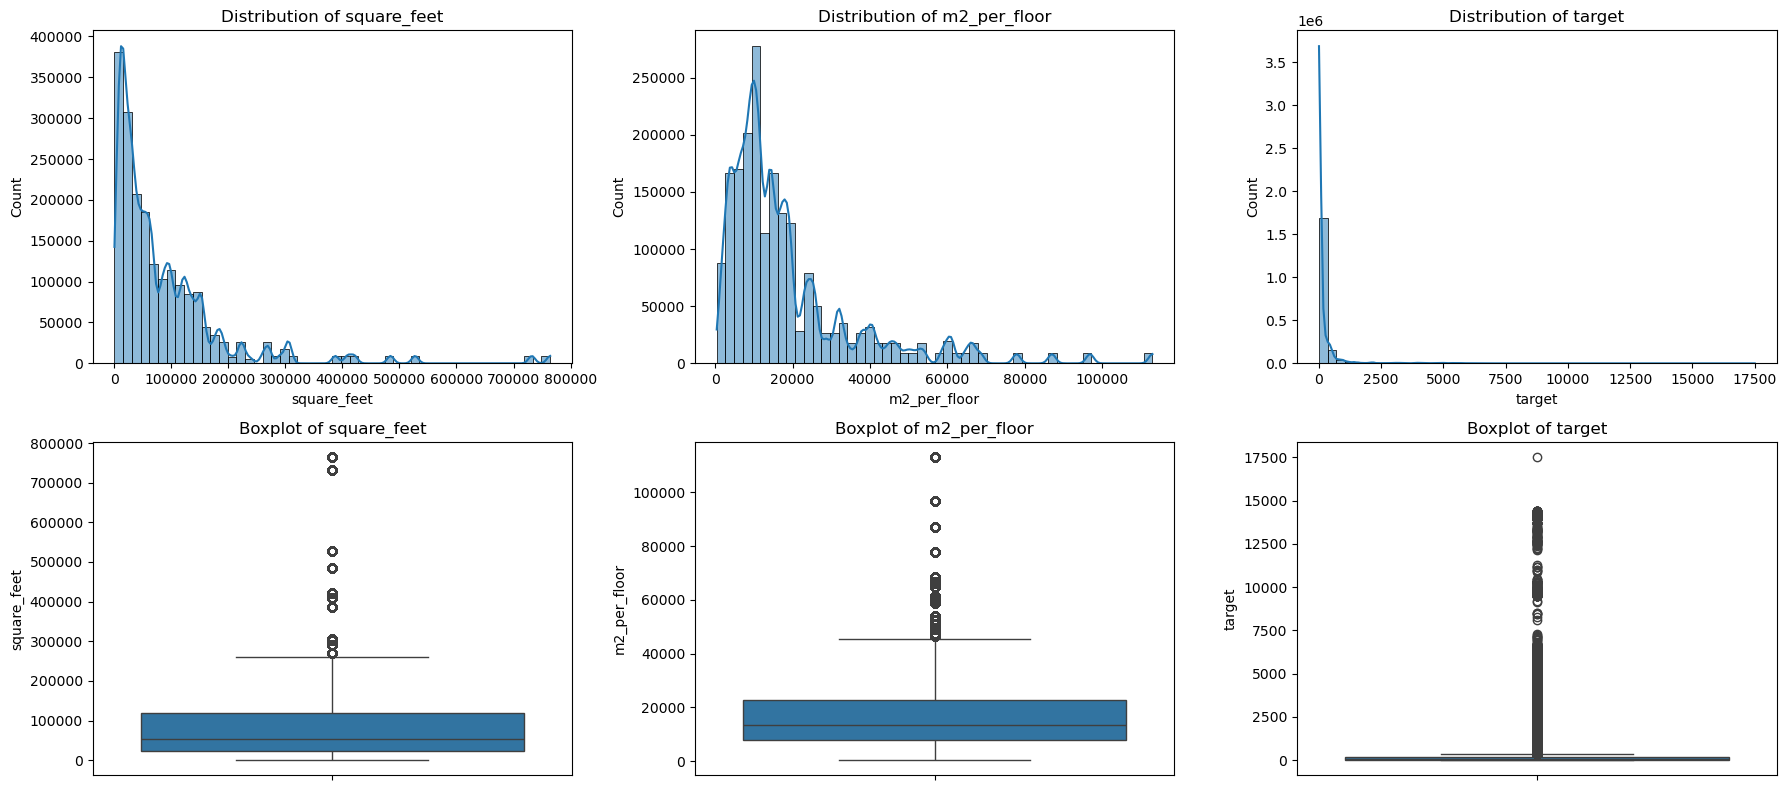

In [21]:
columns = ["square_feet", "m2_per_floor", "target"]

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(columns):
    # Histogram with KDE
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    
    # Boxplot
    sns.boxplot(y=df[col], ax=axes[i + 3])
    axes[i + 3].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [22]:

log_cols = ["square_feet", "m2_per_floor", "target"] #, "lag_1h", "lag_6h", "lag_8h"]
df[log_cols] = np.log1p(df[log_cols])




In [23]:
df.head()

,building_id,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,day,weekday,month,m2_per_floor,target
0,107,1,0,11.487946,2005.0,10.0,3.8,0.0,2.4,0.0,0,1,4,1,9.185453,5.171529
1,108,1,0,11.309352,1913.0,5.0,3.8,0.0,2.4,0.0,0,1,4,1,9.699963,4.524668
2,109,1,0,10.950736,1953.0,6.0,3.8,0.0,2.4,0.0,0,1,4,1,9.159065,4.405865
3,110,1,0,10.233331,2006.0,8.0,3.8,0.0,2.4,0.0,0,1,4,1,8.154141,4.468529
4,111,1,0,11.681309,1909.0,7.0,3.8,0.0,2.4,0.0,0,1,4,1,9.735449,5.126295


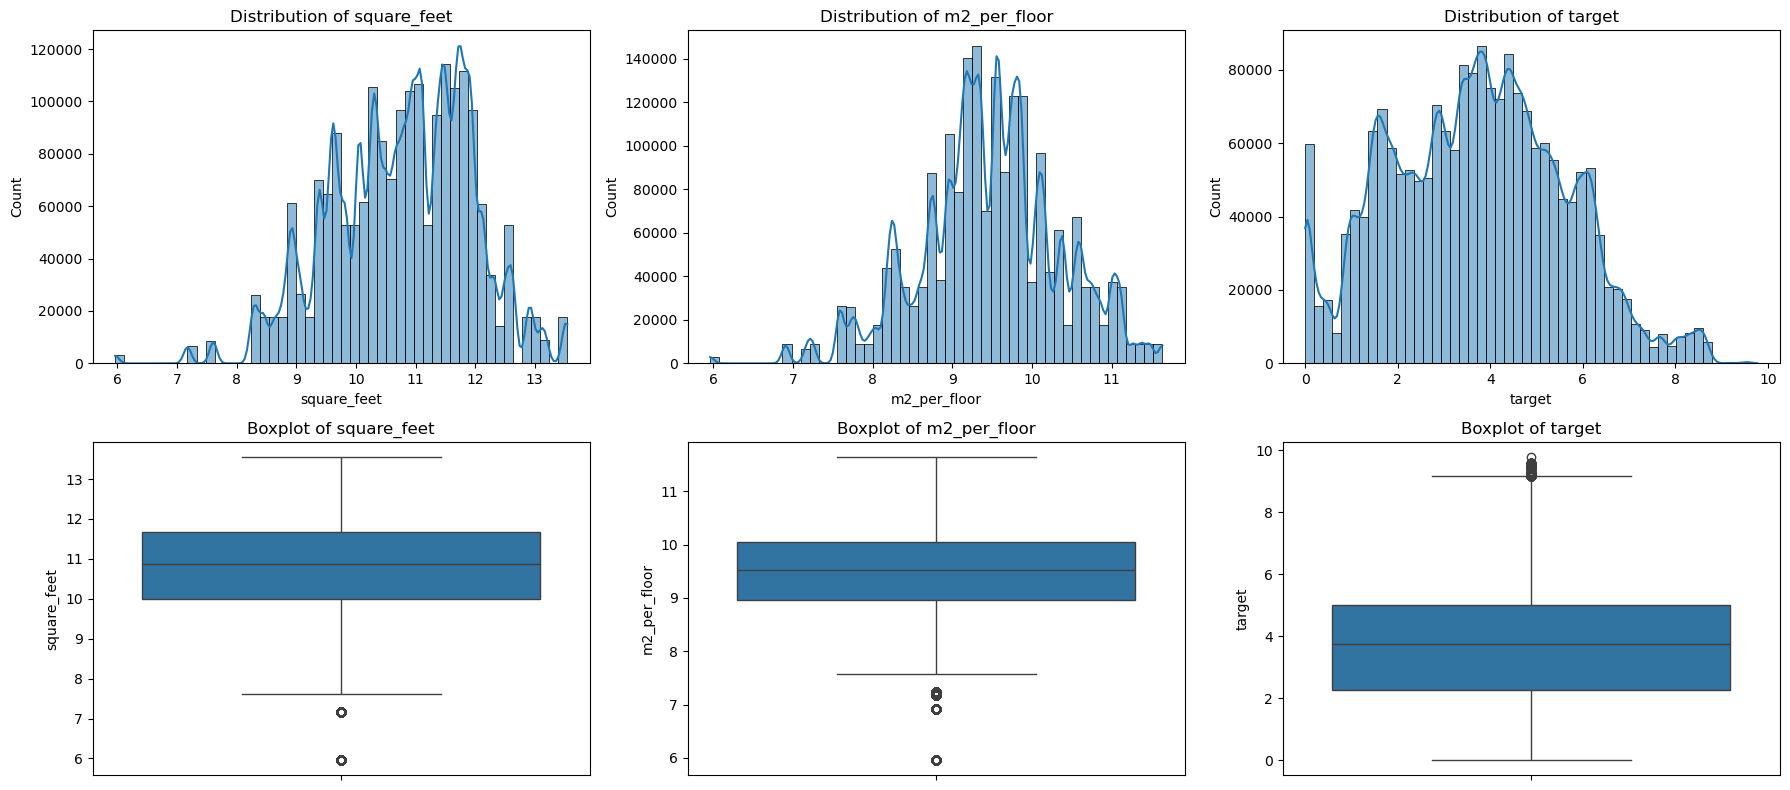

In [24]:
columns = ["square_feet", "m2_per_floor", "target"]

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(columns):
    # Histogram with KDE
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    
    # Boxplot
    sns.boxplot(y=df[col], ax=axes[i + 3])
    axes[i + 3].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


In [25]:
df.to_csv('../data/energy_data_cleaned.csv', index=False)

# Summary of Workflow

1. **Data Cleaning**:
    - Checked for missing values using `isnull().sum()`.
    - Converted the `timestamp` column to datetime format for time-based analysis.
    - Dropped the `timestamp` column after extracting relevant time features.

2. **Feature Engineering**:
    - Created new time-based features: `hour`, `day`, `weekday`, and `month`.
    - Calculated `m2_per_floor` as `square_feet / floor_count` to derive a new feature.
    - Encoded categorical variables like `primary_use` using `LabelEncoder`.

3. **Data Transformation**:
    - Applied logarithmic transformation to columns (`square_feet`, `m2_per_floor`, `target`) to reduce skewness.
    - Normalized numerical columns (`year_built`, `floor_count`, etc.) using `MinMaxScaler`.

4. **Exploratory Data Analysis (EDA)**:
    - Visualized the target variable (`energy consumption`) over time using line plots.
    - Analyzed data by `site_id`, `primary_use`, and `year_built` using bar and line plots.
    - Examined the distribution of `floor_count` and other features using count plots.
    - Created heatmaps to visualize correlations between features.

5. **Time-Based Analysis**:
    - Grouped data by `hour` and `weekday` to analyze median energy consumption for each `primary_use`.
    - Plotted hourly and weekly trends for different `primary_use` categories.

6. **Data Export**:
    - Saved the cleaned and transformed dataset to a new CSV file (`energy_data_cleaned.csv`) for further use.

This workflow combines data cleaning, feature engineering, and visualization to prepare the dataset for modeling and analysis.


| **Feature Name**       | **Feature Description**                                                                 |
|-------------------------|-----------------------------------------------------------------------------------------|
| `building_id`          | Unique identifier for each building.                                                   |
| `site_id`              | Identifier for the site where the building is located.                                 |
| `primary_use`          | The primary purpose of the building (e.g., Education, Office, Healthcare, etc.).       |
| `square_feet`          | Total square footage of the building.                                                  |
| `year_built`           | Year the building was constructed.                                                     |
| `floor_count`          | Number of floors in the building.                                                      |
| `air_temperature`      | Air temperature (in degrees Celsius).                                                  |
| `cloud_coverage`       | Cloud coverage percentage.                                                             |
| `dew_temperature`      | Dew point temperature (in degrees Celsius).                                            |
| `precip_depth_1_hr`    | Precipitation depth in the last hour (in millimeters).                                  |
| `hour`                 | Hour of the day (extracted from the timestamp).                                        |
| `day`                  | Day of the month (extracted from the timestamp).                                       |
| `weekday`              | Day of the week (0 = Monday, 6 = Sunday).                                              |
| `month`                | Month of the year (extracted from the timestamp).                                      |
| `m2_per_floor`         | Average square meters per floor (`square_feet / floor_count`).                         |
| `target`               | Energy consumption (meter reading) in kilowatt-hours (kWh).                            |
